In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import pickle
import nltk
import string
import os
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Download NLTK stopwords
nltk.download('stopwords', quiet=True)

# Configure plotting
plt.style.use('bmh')
sns.set_palette('Set2')

In [3]:
# Section 2: Data Loading and Initial Inspection
def load_reviews(file_path):
    """Load review dataset and display basic information."""
    print("Loading review dataset...")
    data = pd.read_csv(file_path)
    print(f"Dataset shape: {data.shape}")
    print("\nColumn Information:")
    print(data.info())
    print("\nMissing Values:")
    print(data.isnull().sum())
    print("\nSample Data (first 5 rows):")
    print(data.head())
    return data

# Load dataset
file_path = r"C:\Users\theod\Downloads\UAS_PenalaranKomputer\notebook\data\GojekAppReview_Processed.csv"
review_data = load_reviews(file_path)

# Rename sentiment labels to English
review_data['sentiment'] = review_data['sentiment_label'].replace({
    'positif': 'positive',
    'netral': 'neutral',
    'negatif': 'negative'
})

# Drop original sentiment column
review_data = review_data.drop(columns=['sentiment_label'])

# Display sentiment distribution
print("\nSentiment Distribution:")
print(review_data['sentiment'].value_counts())

Loading review dataset...
Dataset shape: (225002, 6)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225002 entries, 0 to 225001
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   userName         225002 non-null  object
 1   content          225000 non-null  object
 2   score            225002 non-null  int64 
 3   at               225002 non-null  object
 4   appVersion       225002 non-null  object
 5   sentiment_label  225002 non-null  object
dtypes: int64(1), object(5)
memory usage: 10.3+ MB
None

Missing Values:
userName           0
content            2
score              0
at                 0
appVersion         0
sentiment_label    0
dtype: int64

Sample Data (first 5 rows):
                  userName                                            content  \
0                Yuga Edit                            akun gopay saya di blok   
1                 ff burik  Lambat sekali sek

In [4]:
# Section 3: Data Splitting
def split_data(data, text_col='content', label_col='sentiment', test_size=0.2):
    """Split data into training and testing sets."""
    X = data[text_col].fillna('')  # Handle missing values
    y = data[label_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")
    return X_train, X_test, y_train, y_test

# Split data
X_train, X_test, y_train, y_test = split_data(review_data)

Training set size: 180001
Testing set size: 45001


In [5]:
# Section 4: Feature Engineering
def vectorize_text(X_train, X_test, method='tfidf'):
    """Vectorize text data using TF-IDF."""
    print(f"\nApplying {method.upper()} vectorization...")
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    print(f"{method.upper()} feature matrix shape: {X_train_vec.shape}")
    print(f"Number of features: {len(vectorizer.get_feature_names_out())}")
    return X_train_vec, X_test_vec, vectorizer

# TF-IDF Vectorization
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = vectorize_text(X_train, X_test, method='tfidf')

# FastText Embeddings
def train_fasttext_embeddings(texts):
    """Train FastText model for word embeddings."""
    print("\nTraining FastText model...")
    tokenized_texts = [text.lower().translate(str.maketrans('', '', string.punctuation)).split() for text in texts]
    model = FastText(
        sentences=tokenized_texts,
        vector_size=100,
        window=5,
        min_count=5,
        workers=4,
        sg=1,
        epochs=10
    )
    print("FastText model trained successfully")
    return model

# Train FastText
fasttext_model = train_fasttext_embeddings(X_train)

# Prepare sequences for deep learning
def prepare_sequences(X_train, X_test, max_words=5000, max_length=100):
    """Tokenize and pad text sequences for deep learning."""
    print("\nPreparing sequences for deep learning...")
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
    print(f"Padded sequence shape: {X_train_pad.shape}")
    return X_train_pad, X_test_pad, tokenizer

# Prepare padded sequences
X_train_pad, X_test_pad, tokenizer = prepare_sequences(X_train, X_test)

# Create embedding matrix for FastText
def create_embedding_matrix(tokenizer, fasttext_model, max_words=5000):
    """Create embedding matrix from FastText model."""
    embedding_dim = fasttext_model.vector_size
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((max_words, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_words:
            try:
                embedding_vector = fasttext_model.wv[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                # If word not in FastText vocab, leave as zeros
                pass
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer, fasttext_model)


Applying TFIDF vectorization...
TFIDF feature matrix shape: (180001, 44775)
Number of features: 44775

Training FastText model...
FastText model trained successfully

Preparing sequences for deep learning...
Padded sequence shape: (180001, 100)


In [7]:
# Section 5: Model Training
# Naive Bayes with TF-IDF
def train_naive_bayes(X_train, X_test, y_train, y_test):
    """Train and evaluate Naive Bayes model."""
    print("\nTraining Naive Bayes (TF-IDF)...")
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    print("\nNaive Bayes (TF-IDF) Performance:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1: {metrics['f1']:.4f}")
    return nb_model, metrics

nb_model, nb_metrics = train_naive_bayes(X_train_tfidf, X_test_tfidf, y_train, y_test)


Training Naive Bayes (TF-IDF)...

Naive Bayes (TF-IDF) Performance:
Accuracy: 0.8877
Precision: 0.9032
Recall: 0.8877
F1: 0.8719


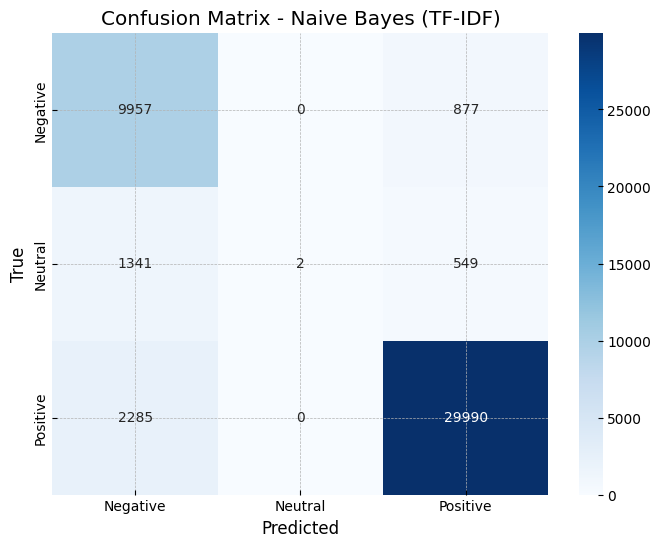

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions for Naive Bayes
y_pred_nb = nb_model.predict(X_test_tfidf)

# Compute confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=['negative', 'neutral', 'positive'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Naive Bayes (TF-IDF)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Vectorize the entire dataset
X_all_tfidf = tfidf_vectorizer.transform(review_data['content'].fillna(''))
y_all = review_data['sentiment']

# Perform 5-fold cross-validation
nb_cv_scores = cross_val_score(MultinomialNB(), X_all_tfidf, y_all, cv=skf, scoring='accuracy')

# Print results
print("Naive Bayes 5-Fold Cross-Validation Accuracy:")
print(f"Scores: {nb_cv_scores}")
print(f"Mean Accuracy: {nb_cv_scores.mean():.4f}")
print(f"Standard Deviation: {nb_cv_scores.std():.4f}")

Naive Bayes 5-Fold Cross-Validation Accuracy:
Scores: [0.88866914 0.88749139 0.88773333 0.88686667 0.89013333]
Mean Accuracy: 0.8882
Standard Deviation: 0.0011


In [10]:
# Encode labels for GRU
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Define GRU model with FastText embeddings
def build_gru_model_with_fasttext(embedding_matrix, max_length=100, num_classes=3):
    """Build GRU model with pre-trained FastText embeddings."""
    model = Sequential([
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=False  # Keep FastText embeddings fixed
        ),
        GRU(64, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and train GRU model
gru_model = build_gru_model_with_fasttext(embedding_matrix)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\nTraining GRU with FastText embeddings...")
history = gru_model.fit(
    X_train_pad, y_train_encoded,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_pad, y_test_encoded),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate GRU model
def evaluate_gru_model(model, X_test, y_test, label_encoder):
    """Evaluate GRU model and return performance metrics."""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    metrics = {
        'accuracy': accuracy_score(y_test_labels, y_pred_labels),
        'precision': precision_score(y_test_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_test_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_test_labels, y_pred_labels, average='weighted')
    }
    return metrics

gru_metrics = evaluate_gru_model(gru_model, X_test_pad, y_test_encoded, label_encoder)

print("\nGRU (FastText) Performance:")
print(f"Accuracy: {gru_metrics['accuracy']:.4f}")
print(f"Precision: {gru_metrics['precision']:.4f}")
print(f"Recall: {gru_metrics['recall']:.4f}")
print(f"F1: {gru_metrics['f1']:.4f}")


Training GRU with FastText embeddings...
Epoch 1/20
11251/11251 [==============================] - 111s 10ms/step - loss: 0.7213 - accuracy: 0.7171 - val_loss: 0.7147 - val_accuracy: 0.7172
Epoch 2/20
11251/11251 [==============================] - 112s 10ms/step - loss: 0.3973 - accuracy: 0.8657 - val_loss: 0.3309 - val_accuracy: 0.8890
Epoch 3/20
11251/11251 [==============================] - 112s 10ms/step - loss: 0.3280 - accuracy: 0.8935 - val_loss: 0.3153 - val_accuracy: 0.8947
Epoch 4/20
11251/11251 [==============================] - 112s 10ms/step - loss: 0.3190 - accuracy: 0.8965 - val_loss: 0.3098 - val_accuracy: 0.8960
Epoch 5/20
11251/11251 [==============================] - 112s 10ms/step - loss: 0.3114 - accuracy: 0.8987 - val_loss: 0.3192 - val_accuracy: 0.8948
Epoch 6/20
11251/11251 [==============================] - 112s 10ms/step - loss: 0.3061 - accuracy: 0.9009 - val_loss: 0.3088 - val_accuracy: 0.8964
Epoch 7/20
11251/11251 [==============================] - 113s 1

1407/1407 [==============================] - 6s 4ms/step


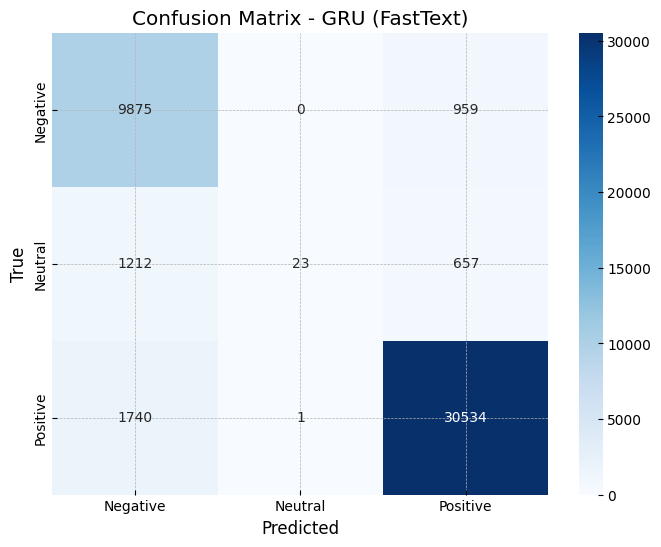

In [11]:
# Predictions for GRU
y_pred_gru = gru_model.predict(X_test_pad)
y_pred_gru_classes = np.argmax(y_pred_gru, axis=1)
y_pred_gru_labels = label_encoder.inverse_transform(y_pred_gru_classes)

# Compute confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_gru_labels, labels=['negative', 'neutral', 'positive'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - GRU (FastText)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
from tensorflow.keras.utils import to_categorical

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics
gru_cv_scores = []

# Perform 5-fold cross-validation
for train_index, test_index in skf.split(review_data['content'].fillna(''), review_data['sentiment']):
    # Split data
    X_train_fold = review_data['content'].fillna('').iloc[train_index]
    X_test_fold = review_data['content'].fillna('').iloc[test_index]
    y_train_fold = review_data['sentiment'].iloc[train_index]
    y_test_fold = review_data['sentiment'].iloc[test_index]
    
    # Prepare sequences
    X_train_pad_fold, X_test_pad_fold, tokenizer_fold = prepare_sequences(X_train_fold, X_test_fold)
    
    # Encode labels
    y_train_encoded_fold = label_encoder.fit_transform(y_train_fold)
    y_test_encoded_fold = label_encoder.transform(y_test_fold)
    
    # Create embedding matrix
    embedding_matrix_fold = create_embedding_matrix(tokenizer_fold, fasttext_model)
    
    # Build and train GRU model
    gru_model_fold = build_gru_model_with_fasttext(embedding_matrix_fold)
    gru_model_fold.fit(
        X_train_pad_fold, y_train_encoded_fold,
        epochs=20, batch_size=16,
        validation_data=(X_test_pad_fold, y_test_encoded_fold),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )
    
    # Evaluate model
    y_pred_fold = gru_model_fold.predict(X_test_pad_fold)
    y_pred_classes_fold = np.argmax(y_pred_fold, axis=1)
    y_pred_labels_fold = label_encoder.inverse_transform(y_pred_classes_fold)
    accuracy = accuracy_score(y_test_fold, y_pred_labels_fold)
    gru_cv_scores.append(accuracy)

# Print results
print("GRU (FastText) 5-Fold Cross-Validation Accuracy:")
print(f"Scores: {gru_cv_scores}")
print(f"Mean Accuracy: {np.mean(gru_cv_scores):.4f}")
print(f"Standard Deviation: {np.std(gru_cv_scores):.4f}")


Preparing sequences for deep learning...
Padded sequence shape: (180001, 100)
1407/1407 [==============================] - 6s 4ms/step

Preparing sequences for deep learning...
Padded sequence shape: (180001, 100)
1407/1407 [==============================] - 6s 4ms/step

Preparing sequences for deep learning...
Padded sequence shape: (180002, 100)
1407/1407 [==============================] - 6s 4ms/step

Preparing sequences for deep learning...
Padded sequence shape: (180002, 100)
1407/1407 [==============================] - 7s 5ms/step

Preparing sequences for deep learning...
Padded sequence shape: (180002, 100)
1407/1407 [==============================] - 6s 4ms/step
GRU (FastText) 5-Fold Cross-Validation Accuracy:
Scores: [0.7171840625763872, 0.7172062843047933, 0.8988888888888888, 0.8987333333333334, 0.901]
Mean Accuracy: 0.8266
Standard Deviation: 0.0893


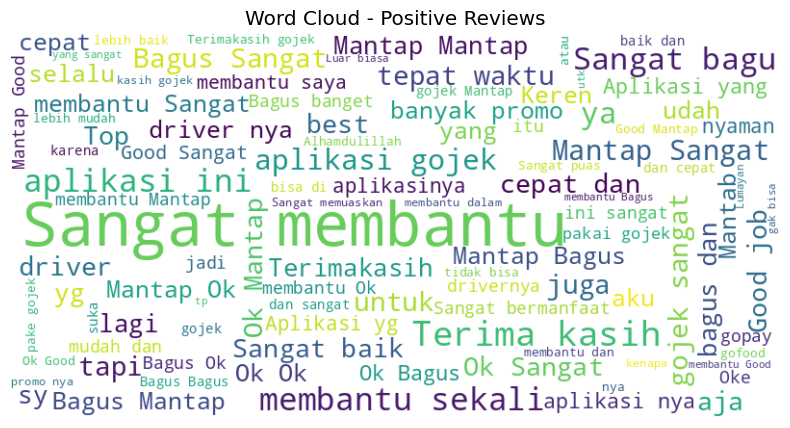

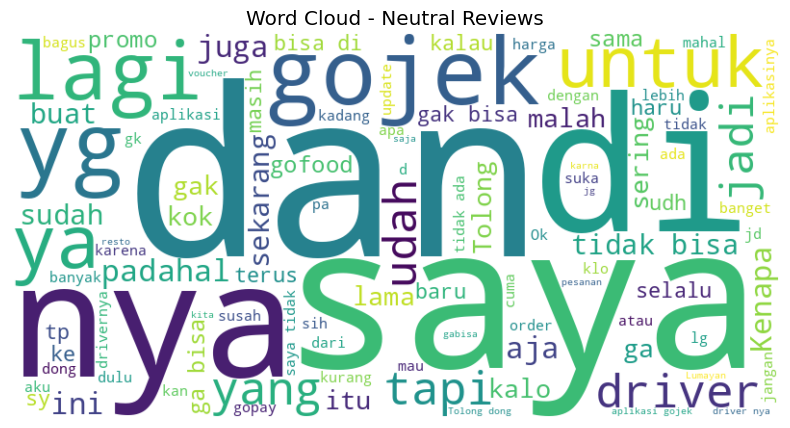

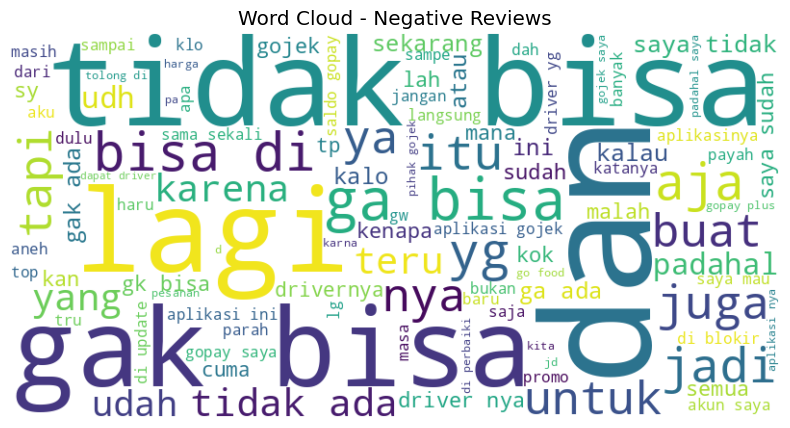

c:\Users\theod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.



c:\Users\theod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.



c:\Users\theod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.



In [13]:
# Section 6: Visualizations
# Model comparison
models = ['Naive Bayes (TF-IDF)', 'GRU (FastText)']
metrics = [nb_metrics, gru_metrics]
fig = px.bar(
    x=[m['accuracy'] for m in metrics] + [m['precision'] for m in metrics] +
        [m['recall'] for m in metrics] + [m['f1'] for m in metrics],
    y=models * 4,
    color=['Accuracy']*2 + ['Precision']*2 + ['Recall']*2 + ['F1 Score']*2,
    barmode='group',
    title='Model Performance Comparison (Naive Bayes vs GRU with FastText)'
)
fig.update_layout(xaxis_title='Score', yaxis_title='Model', showlegend=True)
fig.show()

# Word clouds
def plot_wordcloud(text, title):
    """Generate and display a word cloud."""
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

for sentiment in ['positive', 'neutral', 'negative']:
    text = ' '.join(review_data[review_data['sentiment'] == sentiment]['content'].dropna().astype(str))
    plot_wordcloud(text, f'Word Cloud - {sentiment.capitalize()} Reviews')

# N-gram analysis
def top_ngrams(corpus, ngram_range=(1, 1), n=10):
    """Get top N n-grams from corpus."""
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=nltk.corpus.stopwords.words('indonesian')).fit(corpus)
    bow = vec.transform(corpus)
    word_freq = [(word, bow.sum(axis=0)[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(word_freq, key=lambda x: x[1], reverse=True)[:n]

for sentiment in ['positive', 'neutral', 'negative']:
    texts = review_data[review_data['sentiment'] == sentiment]['content'].dropna().astype(str)
    top_words = top_ngrams(texts, (1, 1), 10)
    fig = px.bar(x=[w[1] for w in top_words], y=[w[0] for w in top_words], 
                 title=f'Top 10 Words in {sentiment.capitalize()} Reviews')
    fig.update_layout(xaxis_title='Frequency', yaxis_title='Words')
    fig.show()

# Review length distribution
review_data['content_length'] = review_data['content'].dropna().apply(len)
fig = px.histogram(
    review_data, x='content_length', color='sentiment', nbins=50,
    title='Review Length Distribution by Sentiment',
    labels={'content_length': 'Review Length (characters)', 'count': 'Density'}
)
fig.show()

# Sentiment trends over time
review_data['date'] = pd.to_datetime(review_data['at']).dt.date
sentiment_trends = review_data.groupby(['date', 'sentiment']).size().unstack().fillna(0)
sentiment_trends = sentiment_trends.div(sentiment_trends.sum(axis=1), axis=0)
fig = px.line(sentiment_trends, title='Sentiment Trends Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Proportion', showlegend=True)
fig.show()

In [14]:
# Section 7: Save Models and Components
save_dir = "saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save Naive Bayes and TF-IDF Vectorizer
with open(os.path.join(save_dir, "naive_bayes_model.pkl"), "wb") as f:
    pickle.dump(nb_model, f)

with open(os.path.join(save_dir, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# Save GRU model, tokenizer, and label encoder
gru_model.save(os.path.join(save_dir, "gru_fasttext_model.h5"))
with open(os.path.join(save_dir, "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)
with open(os.path.join(save_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# Save FastText model
fasttext_model.save(os.path.join(save_dir, "fasttext_model.model"))

# Save evaluation metrics
with open(os.path.join(save_dir, "nb_metrics.pkl"), "wb") as f:
    pickle.dump(nb_metrics, f)
with open(os.path.join(save_dir, "gru_fasttext_metrics.pkl"), "wb") as f:
    pickle.dump(gru_metrics, f)

print("All models and components saved in directory:", save_dir)

All models and components saved in directory: saved_models
